# Screening Rates

## Screening implementations

pynucastro currently has 4 screening implementations:

* `screen5` based on {cite:t}`Wallace:1982`
* `potekhin_1998` based on {cite:t}`chabrier_potekhin:1998`
* `chugunov_2007` based on {cite:t}`chugunov:2007`
* `chugunov_2009` based on {cite:t}`chugunov:2009`

Each of these use various approximations to account for the influence of the plasma on screening the electric charge of the nuclei that are fusing.

## Using screening

To compute the screening factor for a rate, we need to know the entire composition (since the electron number density matters) as well as the two nuclei involved in the reaction.  There are two special types that store this information:

* `PlasmaState` : stores the aggregate information about the entire plasma
* `ScreenFactors` : stores the information about the two nuclei

We create these objects separate before we call the screening routine since there are some computational expensive calculations here that don't change with repeated calls.

Here we create a `PlasmaState` that knows about the conditions where the screening is taking place and then we use that to compute the screening factor for a rate.  The helper function
`make_plasma_state` can create the `PlasmaState` object

In [1]:
import pynucastro as pyna

In [2]:
nuclei = [pyna.Nucleus("h1"),
          pyna.Nucleus("he4"),
          pyna.Nucleus("c12"),
          pyna.Nucleus("o16"),
          pyna.Nucleus("n14"),
          pyna.Nucleus("ca40")]

comp = pyna.Composition(nuclei)
comp.set_solar_like()

dens = 1.e6
temp = 1.e8

plasma = pyna.make_plasma_state(temp, dens, comp.get_molar())

Now let's get the ${}^{12}\mathrm{C}(\alpha,\gamma){}^{16}\mathrm{O}$ rate and compute the screening factor

In [3]:
reaclib_library = pyna.ReacLibLibrary()
rfilter = pyna.RateFilter(reactants=["c12", "he4"], products=["o16"])
r = reaclib_library.filter(rfilter).get_rates()[0]
r

C12 + He4 ⟶ O16 + 𝛾

For the rate, we need the `ScreenFactor`

In [4]:
scn_fac = pyna.make_screen_factors(r.ion_screen[0], r.ion_screen[1])

Finally, we'll select the Chugunov (2009) screening and compute the screening factor.  All of the needed thermodynamic information is contained in the `PlasmaState` and all of the needed
reaction rate information is contained in the `ScreenFactor`

In [5]:
from pynucastro.screening import chugunov_2009

In [6]:
scn = chugunov_2009(plasma, scn_fac)
scn

4.420768407699876

## Screening map

For a `RateCollection` or a network derived from it, there are a lot of rates that will need to be screened, and some might have the same nuclei that need to be screened.  A "screening map" keeps track of all of the rates that need to be screened for the same set of reactants.

```{note}
Some networks (like the `aprox` networks in the literature) use the same screening factor for the forward and reverse rates.  A `RateCollection` takes a keyword argument `symmetric_screening` that tells the network to use the same screening for forward and reverse.  The screening map will then take this into account.
```

The screening map returns a list of `ScreeningPair` objects which contain
the pair of nuclei that need a screening factor computed as well as the list of all
the rates that screening factor applies to.

Here's an example: let's build a helium and carbon burning network.

In [7]:
mynet = reaclib_library.linking_nuclei(["p", "n", "he4", "c12", "o16",
                                        "na23", "mg24", "ne20"])
pynet = pyna.PythonNetwork(libraries=[mynet])

/home/zingale/development/pynucastro/pynucastro/networks/rate_collection.py:576: UserWarning: ReacLib neutron decay rate (<n_to_p_weak_wc12>) does not account for degeneracy at high densities. Consider using tabular rate from Langanke.
  warnings.warn(msg)


From the `RateCollection`, we can get the screening map (the list of `ScreeningPair` objects)

In [8]:
from pynucastro.screening import get_screening_map
screen_map = get_screening_map(pynet.get_rates(), symmetric_screening=pynet.symmetric_screening)

In [9]:
for s in screen_map:
    print(s)

screening for He4 + C12
rates:
  C12 + He4 ⟶ O16 + 𝛾

screening for He4 + O16
rates:
  O16 + He4 ⟶ Ne20 + 𝛾

screening for He4 + Ne20
rates:
  Ne20 + He4 ⟶ Mg24 + 𝛾
  Ne20 + He4 ⟶ p + Na23
  Ne20 + He4 ⟶ C12 + C12

screening for p + Na23
rates:
  Na23 + p ⟶ Mg24 + 𝛾
  Na23 + p ⟶ He4 + Ne20
  Na23 + p ⟶ C12 + C12

screening for C12 + C12
rates:
  C12 + C12 ⟶ p + Na23
  C12 + C12 ⟶ He4 + Ne20

screening for C12 + O16
rates:
  O16 + C12 ⟶ He4 + Mg24

screening for He4 + Mg24
rates:
  Mg24 + He4 ⟶ C12 + O16

screening for He4 + He4
rates:
  He4 + He4 + He4 ⟶ C12 + 𝛾

screening for He4 + Be8
rates:
  He4 + He4 + He4 ⟶ C12 + 𝛾



Here we see that the screening for some pairs of nuclei (like $p + {}^{23}\mathrm{Na}$) apply to several rates.

## Screening and a python network

When we write out the module that defines a python network, it contains all of the information needed to define the righthand side and Jacobian, if screening is not used.  But the `rhs` and `jacobian` functions can take an optional argument that is the name of the screening function to use, and if this is provided, then the rates will be screened.  Here we demonstrate this.

In [10]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp

In [11]:
pynet.write_network("cburn.py")
import cburn

First we'll run with screening.  Here we pass the name of the screening function to the `rhs` and `jacobian` function through the `args` keyword

We'll pick conditions appropriate for the center of a Chandra mass white dwarf just after a carbon flame ignites.

In [12]:
rho = 1.e9
T = 2.e9

X0 = np.zeros(cburn.nnuc)
X0[cburn.jc12] = 0.5
X0[cburn.jo16] = 0.5

Y0 = X0/cburn.A

tmax = 1000.0

sol = solve_ivp(cburn.rhs, [0, tmax], Y0, method="BDF", jac=cburn.jacobian,
                dense_output=True, args=(rho, T, chugunov_2009), rtol=1.e-6, atol=1.e-10)

Now we run without screening:

In [13]:
sol_noscreen = solve_ivp(cburn.rhs, [0, tmax], Y0, method="BDF", jac=cburn.jacobian,
                         dense_output=True, args=(rho, T), rtol=1.e-6, atol=1.e-10)

and we can plot the two cases together.  The non-screened X's will be shown with a dotted line.

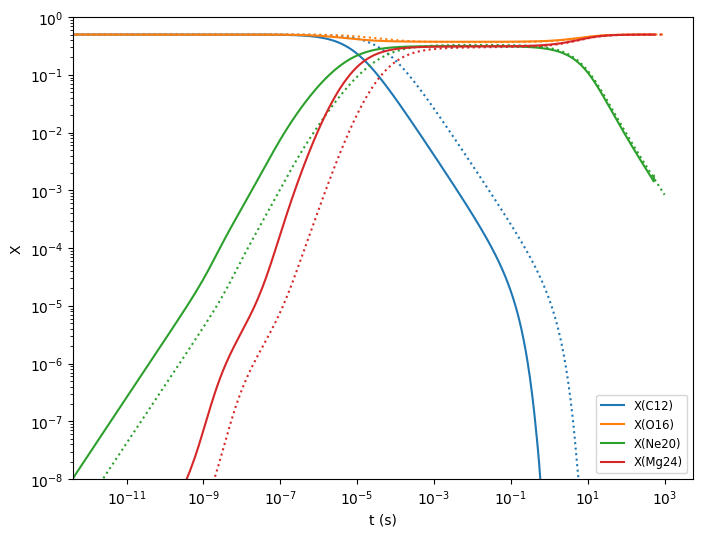

In [14]:
fig = plt.figure()
ax = fig.add_subplot(111)

threshold = 1.e-4

icolor = 0
for i in range(cburn.nnuc):
    if (sol.y[i,:]).max() > threshold:
        ax.loglog(sol.t, sol.y[i,:] * cburn.A[i],
                  label=f"X({cburn.names[i].capitalize()})",
                  color=f"C{icolor}")
        ax.loglog(sol_noscreen.t, sol_noscreen.y[i,:] * cburn.A[i],
                  linestyle=":", color=f"C{icolor}")
        icolor += 1
        
ax.set_ylim(1.e-8, 1.0)
ax.legend(fontsize="small")
ax.set_xlabel("t (s)")
ax.set_ylabel("X")

fig.set_size_inches((8, 6))

As expected, using screening makes the carbon burn much more quickly.